In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from itertools import cycle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn import  metrics
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical 
from sklearn.ensemble import RandomForestClassifier

from datetime import datetime


## EDA & Insights

In [34]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train_alt = pd.read_csv('train.csv')
print(df_train.describe)
df_train.isnull().sum(), df_test.isnull().sum()

<bound method NDFrame.describe of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

     

(label       0
 pixel0      0
 pixel1      0
 pixel2      0
 pixel3      0
            ..
 pixel779    0
 pixel780    0
 pixel781    0
 pixel782    0
 pixel783    0
 Length: 785, dtype: int64,
 pixel0      0
 pixel1      0
 pixel2      0
 pixel3      0
 pixel4      0
            ..
 pixel779    0
 pixel780    0
 pixel781    0
 pixel782    0
 pixel783    0
 Length: 784, dtype: int64)

No null values -> do not need to clean anything

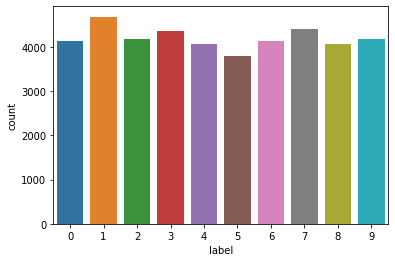

In [35]:
label = df_train["label"]
feature = df_train_alt.drop(labels = ["label"],axis = 1)
g = sns.countplot(x = label)

The count of each labeled number is fairly uniform, nothing skewing to one direction

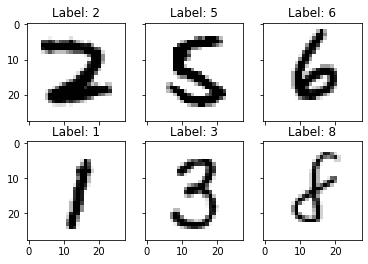

In [36]:
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows,ncols, sharex = True, sharey = True)
for row in range(nrows):
    for col in range(ncols):
        rand_example = np.random.choice(feature.index)
        ax[row, col].imshow(feature.loc[rand_example].values.reshape((28,28)),
                           cmap='gray_r')
        ax[row, col].set_title("Label: {}".format(label.loc[rand_example]))

Generically, this is what the images look like

## Helper Functions

In [37]:
# https://stackoverflow.com/questions/56458526/
# get-confusion-matrix-from-a-keras-model
# made a function because confusion matrix is being reused

def plot_confusion_matrix(cm, classes, title):
   
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [38]:
# https://stackoverflow.com/questions/51047676/how-to-get-
#accuracy-of-model-using-keras
def printAccuracyScores(model, features, labels, title):
    output = model.evaluate(features, labels)
    #print(title +"and {output[1]}".format("string", 1.0))
    msg = title + " Accuracy score is: %f " % (output[1])
    print(msg)

In [39]:
def printAccuracyAndLossCurves(history, title):
    
    fig, ax = plt.subplots(2,1)
    fig.suptitle(title, fontsize=16)
    ax[0].plot(history.history['loss'], color='g', label = "Training loss")
    ax[0].plot(history.history['val_loss'], color='r', 
               label = "validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'], color='g', 
               label = "Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',
               label = "Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

Splitting the dataset

In [40]:
label = to_categorical(label, num_classes = 10)

# normalizing the dataset
feature = feature / 255.0
df_test = df_test / 255.0

# Split into training & validation sets
# 10% validation 90% training split
# stratify used to keep uniformity
feature_train, feature_val, label_train, label_val = \
train_test_split(feature, label, test_size = 0.1, stratify=label)



## Basic Neural Network (2 layers: Input & Output)

In [41]:
naive_neural_model = Sequential()
naive_neural_model.add(Dense(20, activation = "relu", input_shape = (784,)))
naive_neural_model.add(Dense(10, activation = "softmax"))

# Define the optimizer and compile the model
optimizer = optimizers.SGD(learning_rate=0.03, clipnorm=5.)
naive_neural_model.compile(optimizer= optimizer , 
                           loss = "categorical_crossentropy", 
                           metrics=["accuracy"])

print (naive_neural_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 20)                15700     
                                                                 
 dense_11 (Dense)            (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
None


In [42]:

history_naive = naive_neural_model.fit(feature_train, label_train, 
                                 batch_size = 100, epochs = 8, 
          validation_data = (feature_val, label_val), verbose = 1)

Epoch 1/8
378/378 [==============================] - 3s 6ms/step - loss: 0.9087 - accuracy: 0.7593 - val_loss: 0.4969 - val_accuracy: 0.8790
Epoch 2/8
378/378 [==============================] - 1s 3ms/step - loss: 0.4285 - accuracy: 0.8848 - val_loss: 0.3840 - val_accuracy: 0.8971
Epoch 3/8
378/378 [==============================] - 1s 2ms/step - loss: 0.3620 - accuracy: 0.8984 - val_loss: 0.3431 - val_accuracy: 0.9036
Epoch 4/8
378/378 [==============================] - 1s 4ms/step - loss: 0.3323 - accuracy: 0.9059 - val_loss: 0.3214 - val_accuracy: 0.9079
Epoch 5/8
378/378 [==============================] - 2s 5ms/step - loss: 0.3135 - accuracy: 0.9116 - val_loss: 0.3065 - val_accuracy: 0.9131
Epoch 6/8
378/378 [==============================] - 2s 5ms/step - loss: 0.2995 - accuracy: 0.9154 - val_loss: 0.2968 - val_accuracy: 0.9138
Epoch 7/8
378/378 [==============================] - 2s 6ms/step - loss: 0.2884 - accuracy: 0.9176 - val_loss: 0.2840 - val_accuracy: 0.9164
Epoch 8/8
378

For the naive neural network, it still beats the other modeling techniques used in the previous weeks as the accuracy is extremely high (over 91%). Because we did not manipulate the layer or node count much, we can still improve on this score further

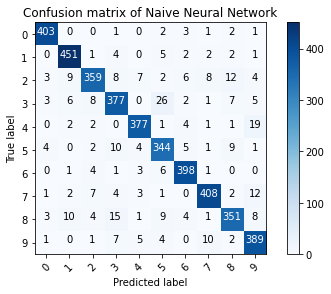

In [83]:
# predictions
naive_prediction = naive_neural_model.predict(feature_val)

# Converting the predictions
naive_prediction_classes = np.argmax(naive_prediction,axis = 1)

# Convert the validation set
naive_y_true_val = np.argmax(label_val,axis = 1) 

confusion_mtx = confusion_matrix(naive_y_true_val, naive_prediction_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10), 
                      title = 'Confusion matrix of Naive Neural Network') 

Good sign that it follows the diagonal, not suprisingly the '1' character is very easy to predict, however, I would have assumed '8' character would be easy to predict as well. I guess the simpler the character, the easier it is to predict

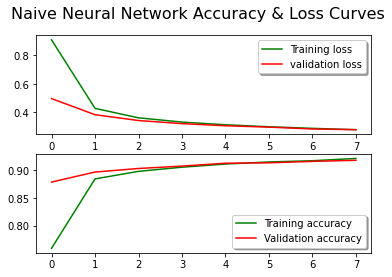

In [44]:
printAccuracyAndLossCurves(history_naive, 
                           "Naive Neural Network Accuracy & Loss Curves")

In [45]:
results = naive_neural_model.predict(df_test)

# select the indix with the maximum probability
results = np.argmax(results, axis = 1)

results = pd.Series(results, name = "Label")

In [46]:
submission = pd.concat([pd.Series(range(1,28001),
                                  name = "ImageId"),results],axis = 1)
submission.to_csv("naive_neural_network.csv",index=False)

## Semi-Dense Neural Network (3 layers)

In [47]:
# https://stats.stackexchange.com/questions/222883/why-are-neural-
# networks-becoming-deeper-but-not-wider
# made the next step of the model more wider and not much deeper
semi_dense_model = Sequential()
semi_dense_model.add(Dense(20, activation = "relu", input_shape = (784,)))
semi_dense_model.add(Dense(60, activation = "relu"))
semi_dense_model.add(Dense(10, activation = "softmax"))

optimizer = optimizers.SGD(learning_rate=0.03, clipnorm=5.)
semi_dense_model.compile(optimizer= optimizer , 
            loss = "categorical_crossentropy", metrics=["accuracy"])

print (semi_dense_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                15700     
                                                                 
 dense_13 (Dense)            (None, 60)                1260      
                                                                 
 dense_14 (Dense)            (None, 10)                610       
                                                                 
Total params: 17,570
Trainable params: 17,570
Non-trainable params: 0
_________________________________________________________________
None


In [48]:

history_semi = semi_dense_model.fit(feature_train, label_train, 
                                    batch_size = 100, epochs = 8, 
          validation_data = (feature_val, label_val), verbose = 1)

Epoch 1/8
378/378 [==============================] - 3s 6ms/step - loss: 1.1497 - accuracy: 0.6509 - val_loss: 0.5399 - val_accuracy: 0.8448
Epoch 2/8
378/378 [==============================] - 2s 6ms/step - loss: 0.4335 - accuracy: 0.8770 - val_loss: 0.3802 - val_accuracy: 0.8929
Epoch 3/8
378/378 [==============================] - 1s 3ms/step - loss: 0.3474 - accuracy: 0.9006 - val_loss: 0.3261 - val_accuracy: 0.9105
Epoch 4/8
378/378 [==============================] - 2s 4ms/step - loss: 0.3110 - accuracy: 0.9102 - val_loss: 0.3024 - val_accuracy: 0.9138
Epoch 5/8
378/378 [==============================] - 1s 3ms/step - loss: 0.2862 - accuracy: 0.9177 - val_loss: 0.2791 - val_accuracy: 0.9188
Epoch 6/8
378/378 [==============================] - 1s 3ms/step - loss: 0.2666 - accuracy: 0.9232 - val_loss: 0.2635 - val_accuracy: 0.9238
Epoch 7/8
378/378 [==============================] - 1s 2ms/step - loss: 0.2512 - accuracy: 0.9277 - val_loss: 0.2537 - val_accuracy: 0.9250
Epoch 8/8
378

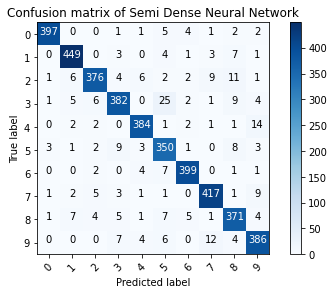

In [84]:
semi_dense_prediction = semi_dense_model.predict(feature_val)
semi_dense_prediction_classes = np.argmax(semi_dense_prediction,axis = 1) 
semi_dense_true_val = np.argmax(label_val,axis = 1) 
confusion_mtx = confusion_matrix(semi_dense_true_val, semi_dense_prediction_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10),
        title = 'Confusion matrix of Semi Dense Neural Network') 

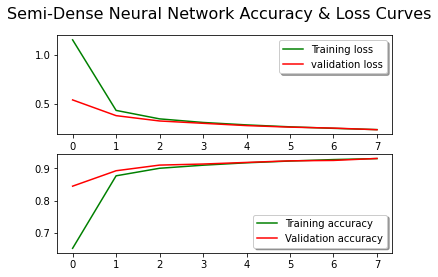

In [50]:
printAccuracyAndLossCurves(history_semi,
            "Semi-Dense Neural Network Accuracy & Loss Curves")

In [51]:
results = semi_dense_model.predict(df_test)

results = np.argmax(results, axis = 1)

results = pd.Series(results, name = "Label")

In [52]:
submission = pd.concat([pd.Series(range(1,28001),
                            name = "ImageId"),results],axis = 1)
submission.to_csv("semi_dense_neural_network.csv",index=False)

## Dense Neural Network (5 layers)

In [73]:
# made the model deeper and wider, funnel approach
dense_neural_model = Sequential()
dense_neural_model.add(Dense(200, activation = "relu", 
                             input_shape = (784,)))
dense_neural_model.add(Dense(100, activation = "relu"))
dense_neural_model.add(Dense(50, activation = "relu"))
dense_neural_model.add(Dense(25, activation = "relu"))
dense_neural_model.add(Dense(10, activation = "softmax"))

# Define the optimizer and compile the model
optimizer = optimizers.SGD(learning_rate = 0.03, clipnorm = 5.)
dense_neural_model.compile(optimizer= optimizer , 
            loss = "categorical_crossentropy", metrics=["accuracy"])

print (dense_neural_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 200)               157000    
                                                                 
 dense_26 (Dense)            (None, 100)               20100     
                                                                 
 dense_27 (Dense)            (None, 50)                5050      
                                                                 
 dense_28 (Dense)            (None, 25)                1275      
                                                                 
 dense_29 (Dense)            (None, 10)                260       
                                                                 
Total params: 183,685
Trainable params: 183,685
Non-trainable params: 0
_________________________________________________________________
None


In [74]:

history_dense = dense_neural_model.fit(feature_train, 
                            label_train, batch_size = 100, epochs = 8, 
          validation_data = (feature_val, label_val), verbose = 1)

Epoch 1/8
378/378 [==============================] - 4s 8ms/step - loss: 0.9327 - accuracy: 0.7207 - val_loss: 0.3975 - val_accuracy: 0.8857
Epoch 2/8
378/378 [==============================] - 3s 7ms/step - loss: 0.3283 - accuracy: 0.9029 - val_loss: 0.2757 - val_accuracy: 0.9202
Epoch 3/8
378/378 [==============================] - 2s 6ms/step - loss: 0.2417 - accuracy: 0.9276 - val_loss: 0.2200 - val_accuracy: 0.9355
Epoch 4/8
378/378 [==============================] - 2s 5ms/step - loss: 0.1921 - accuracy: 0.9430 - val_loss: 0.1778 - val_accuracy: 0.9457
Epoch 5/8
378/378 [==============================] - 2s 5ms/step - loss: 0.1616 - accuracy: 0.9522 - val_loss: 0.1687 - val_accuracy: 0.9505
Epoch 6/8
378/378 [==============================] - 2s 5ms/step - loss: 0.1379 - accuracy: 0.9594 - val_loss: 0.1447 - val_accuracy: 0.9576
Epoch 7/8
378/378 [==============================] - 2s 6ms/step - loss: 0.1208 - accuracy: 0.9643 - val_loss: 0.1350 - val_accuracy: 0.9574
Epoch 8/8
378

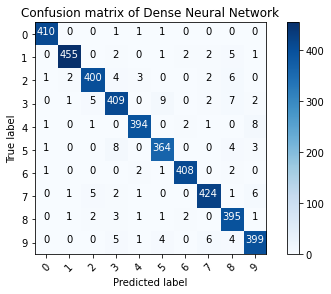

In [85]:
dense_prediction = dense_neural_model.predict(feature_val)
dense_prediction_classes = np.argmax(dense_prediction,axis = 1) 
dense_true_val = np.argmax(label_val,axis = 1) 
confusion_mtx = confusion_matrix(dense_true_val, dense_prediction_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10), 
        title = 'Confusion matrix of Dense Neural Network') 

Seems like '5' was the hardest character to predict. This is understandable as the character can range from various interpretations. 

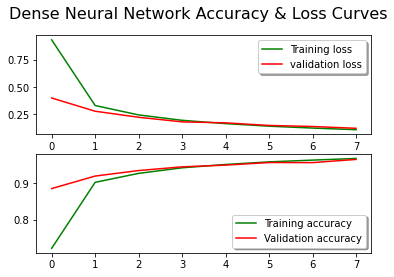

In [76]:
printAccuracyAndLossCurves(history_dense, 
                        "Dense Neural Network Accuracy & Loss Curves")

The accuracy is higher than the other models, as well as the loss graph was higher than usual initially, then it equates closer to the actual loss. 

In [77]:
results = dense_neural_model.predict(df_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [78]:
submission = pd.concat([pd.Series(range(1,28001),
                            name = "ImageId"),results],axis = 1)
submission.to_csv("dense_neural_network.csv",index=False)

## Cross Validating the Scores

In [80]:
printAccuracyScores(naive_neural_model, feature_train, label_train, 
                    title = "Basic Neural Network")

1182/1182 [==============================] - 4s 3ms/step - loss: 0.2735 - accuracy: 0.9213
Basic Neural Network Accuracy score is: 0.921323 


In [81]:
printAccuracyScores(semi_dense_model, feature_train, label_train, 
                    title = "Semi-Dense Neural Network")

1182/1182 [==============================] - 4s 3ms/step - loss: 0.2253 - accuracy: 0.9352
Semi-Dense Neural Network Accuracy score is: 0.935238 


In [82]:
printAccuracyScores(dense_neural_model, feature_train, label_train, 
                    title = "Dense Neural Network")

1182/1182 [==============================] - 3s 3ms/step - loss: 0.0894 - accuracy: 0.9739
Dense Neural Network Accuracy score is: 0.973862 
